# Описание

В этом ноутбуке будет рассмотрен процесс извлечения данных о треках, исполнителях, альбомах и т.д. из музыкального сервиса Spotify посредством программного интерфейса. Из полученных данных будет построен датасет, пригодный для дальнейшего изучения. В ближайшее время будет проведен исследовательский анализ и построение модели машинного обучения для прогнозирования популярности трека.

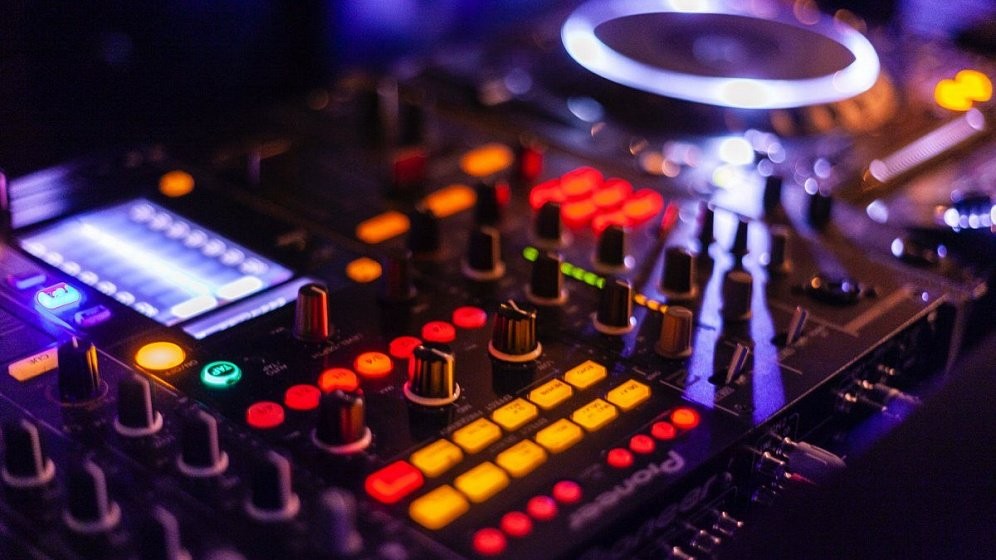

# Импорт библиотек и подключение к API Spotify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import datetime
import base64
import sys
import json
import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2
from urllib.parse import urlencode
from collections import ChainMap
import re
import time
import concurrent.futures
import warnings
import pickle
import datetime as dt
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Запускаем файл с данными для аутентификации

%run secrets.py

credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

# token = credentials.get_access_token()
spotify = spotipy.Spotify(auth_manager=credentials)

Подключение произошло успешно. Можно приступать к работе!

# Получение данных из DJ Mag Top 100

Нужно получить данные об исполнителях из известного рейтинга dj mag top 100, в котором содержатся наиболее известные диджеи и продюсеры в сфере электронной музыки. Необходимо собрать датасет, и для этого придется заняться парсингом сайтов. Далее нужно будет собрать данные о треках исполнителей.

In [3]:
import concurrent.futures

In [4]:
# Составление датафрейма о положении диджеев в рейтинге dj mag top 100


def get_djs_rating_data(year):
    djs = []
    positions = []
    dj_years = []
    movements = []

    url = f'https://djmag.com/top100djs/?year={year}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    name_links = soup.find_all('div', class_='top100dj-name')
    pos_links = soup.find_all(
        'div', class_='views-field views-field-field-top100-position')
    pos_movements = soup.find_all('div', class_='top100dj-movement')

    for l in name_links:  # Имена диджеев
        djs.append(l.text.strip())

    for l in pos_links:  # Позиции в рейтинге
        positions.append(int(l.text.strip()))

    for i in pos_movements:  # Изменение позиций
        movements.append(i.text.strip())

    for i in range(len(pos_movements)):  # Год
        dj_years.append(year)

    djs_df = pd.DataFrame({
        'name': djs,
        'position': positions,
        'position_movement': movements,
        'year': dj_years
    })

    return djs_df

In [5]:
years = np.arange(2004, dt.datetime.now().year)

In [6]:
# %%time
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(get_djs_rating_data, year) for year in years]
#     results = [result.result() for result in futures]
# djs_df = pd.concat(results)

In [7]:
# djs_df.to_csv('Djs_rating_data.csv', index=False)

In [8]:
# Читаем данные о диджеях из записанного в предыдущей ячейке csv файла

djs_df = pd.read_csv('Djs_rating_data.csv')

In [9]:
djs_df.head()

,name,position,position_movement,year
0,Tiësto,1,Re-entry,2004
1,Paul van Dyk,2,Re-entry,2004
2,Armin Van Buuren,3,Re-entry,2004
3,Sasha,4,Re-entry,2004
4,Ferry Corsten,5,Up 1,2004


In [10]:
# Все исполнители, которые хотя бы раз попадали в рейтинг
unique_djs = list(djs_df['name'].unique())
len(unique_djs)

413

# Получение дополнительных данных об исполнителях

In [11]:
def get_more_djs_data(dj):
    djs = []
    born_in = []
    url = f'https://www.last.fm/music/{dj}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    data = soup.find_all('dd', {'class': 'catalogue-metadata-description'})
    result = [i.text for i in data]
    djs.append(dj)

    if len(result) == 2:  # Если даны все данные, берем вторую строку
        born_in.append(result[1])

    elif len(result) == 1:  # Если чего-то одного не хватает (даты или места)
        if len(
                re.findall('\d', str(result))
        ) > 0:  # Если это дата рождения (или продолжительность творческой деятельности)

            url = f'https://www.discogs.com/artist/{dj}'
            r = requests.get(url)
            soup = BeautifulSoup(r.text, 'html.parser')
            data = soup.find('div', {'class': 'readmore', 'id': 'profile'})

            if data is None:
                born_in.append(np.nan)
            else:
                data = data.text.strip()
                born_in.append(data)

        else:
            born_in.append(result[0])
    else:  # Если на last.fm не нашлось данных, поиск продолжится на сайте www.discogs.com
        url = f'https://www.discogs.com/artist/{dj}'
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        data = soup.find('div', {'class': 'readmore', 'id': 'profile'})

        if data is None:
            born_in.append(np.nan)
        else:
            data = data.text.strip()
            born_in.append(data)

    djs_df_1 = pd.DataFrame({'name': djs, 'born_or_founded_in': born_in})
    time.sleep(0.5)

    return djs_df_1

In [12]:
# %%time
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(get_more_djs_data, dj) for dj in unique_djs]
#     results = [result.result() for result in futures]
# djs_df_1 = pd.concat(results).reset_index(drop=True).dropna(subset=['name'])

In [13]:
# djs_df_1.to_csv('Djs_birth_place_data.csv', index=False)

In [14]:
djs_df_1 = pd.read_csv('Djs_birth_place_data.csv')

In [15]:
djs_df_1.isna().sum()

name                   0
born_or_founded_in    32
dtype: int64

In [16]:
# Один из диджеев не нашелся вовсе, поэтому лучше перезаписать переменную unique_djs, чтобы далее не было пропусков

unique_djs = list(djs_df_1['name'])

In [17]:
# Исполнители, страну рождения которых не удалось найти на last.fm

unfound_place_djs = list(djs_df_1[djs_df_1.isna().any(axis=1)]['name'])

In [18]:
djs_df_1.shape

(412, 2)

In [19]:
# pd.set_option('display.max_colwidth', None)

In [20]:
djs_df_1.head()

,name,born_or_founded_in
0,Tiësto,"Breda, Breda, Noord-Brabant, Netherlands"
1,Paul van Dyk,"Eisenhüttenstadt, Brandenburg, Germany"
2,Armin Van Buuren,"Leiden, Zuid-Holland, Netherlands"
3,Sasha,British DJ and producer. \r Born: 4 September ...
4,Ferry Corsten,"Rotterdam, Rotterdam, Zuid-Holland, Netherlands"


# Получение треков

In [21]:
# Получить id диджеев на спотифай
def get_ids(dj):
    dj = dj.upper()
    search = spotify.search(dj, type='artist').get('artists').get('items')
    if len(search)>0:
        names = dict(ChainMap(*search)).get('name').upper()
        id = dict(ChainMap(*search)).get('id')
        if dj==names:
            return id

In [22]:
# djs_ids = [get_ids(i) for i in unique_djs]
# djs_ids = [i for i in djs_ids if i]

In [23]:
# with open("Djs_ids.txt", "w") as f:
#     f.write("\n".join(djs_ids))

In [24]:
with open('Djs_ids.txt') as f:
    djs_ids = f.readlines()
    djs_ids = [x.strip() for x in djs_ids] 

In [25]:
len(djs_ids)

364

In [26]:
def artist_tracks(artist_id):
    try:
        albums_data = spotify.artist_albums(artist_id, limit=50)
        albums = [albums_data.get('items')[i].get('id') for i in range(len(albums_data.get('items')))]
        album_tracks = []

        for n in tqdm_notebook(range(len(albums))):
            album_tracks_data = spotify.album_tracks(albums[n]).get('items')
            for i in range(len(album_tracks_data)):
                if artist_id in [d.get('id') for d in album_tracks_data[i].get('artists')] and album_tracks_data[i].get('duration_ms')>120000:
                    album_tracks.append(album_tracks_data[i].get('id'))
        return album_tracks
    except:
           return [] 

In [27]:
# Функция подсчитывает кол-во альбомов исполнителя (синглы не в счет)

def albums_count(artist_id):
    return [d.get('album_type') for d in spotify.artist_albums(artist_id, limit=50).get('items')].count('album')

In [28]:
# %%time
# track_ids = [artist_tracks(dj) for dj in djs_ids]

In [29]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [30]:
# track_ids = flatten(track_ids)

In [31]:
# with open("Track_ids.txt", "w") as f:
#     f.write("\n".join(track_ids))

In [32]:
with open('Track_ids.txt') as f:
    track_ids = f.readlines()
    track_ids = [x.strip() for x in track_ids] 

In [33]:
len(track_ids)

60504

In [34]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

track_id_chunks = list(chunks(track_ids, 50))

In [35]:
len(track_id_chunks)

1211

# Получение информации о треках

In [36]:
# ConnectionError

In [37]:
# 0SfsnGyD8FpIN4U4WCkBZ5

In [38]:
artist_data = spotify.artist('0SfsnGyD8FpIN4U4WCkBZ5')

In [39]:
artist_data

{'external_urls': {'spotify': 'https://open.spotify.com/artist/0SfsnGyD8FpIN4U4WCkBZ5'},
 'followers': {'href': None, 'total': 4066134},
 'genres': ['dutch trance', 'edm', 'pop dance', 'progressive house', 'trance'],
 'href': 'https://api.spotify.com/v1/artists/0SfsnGyD8FpIN4U4WCkBZ5',
 'id': '0SfsnGyD8FpIN4U4WCkBZ5',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5ebefeb80bd23b299d413c04d8f',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174efeb80bd23b299d413c04d8f',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178efeb80bd23b299d413c04d8f',
   'width': 160}],
 'name': 'Armin van Buuren',
 'popularity': 77,
 'type': 'artist',
 'uri': 'spotify:artist:0SfsnGyD8FpIN4U4WCkBZ5'}

In [40]:
len(track_id_chunks)

1211

In [41]:
def spotify_data_scraper():
    for chunk in range(len(track_id_chunks)):
        try:
            artist_ids = [] # Id исполнителей
            albums_data = [] # Данные об альбомах
            track_data_values = [] # Общая информация о треках
            artist_dicts = [] # Данные об исполнителях
            unique_artist_data = [] # Данные об уникальных исполнителях (нужно для оптимизации парсинга)
            tracks_test = []    

            track_list = track_id_chunks[chunk]
            search = spotify.tracks(track_list).get('tracks')
            audio_features = spotify.audio_features(track_list)

            # Ключи
            track_data_keys = [
                'name', 'id', 'popularity', 'track_number', 'explicit',
                'available_markets'
            ]
            album_keys = ['name', 'id', 'release_date', 'total_tracks']
            artist_keys = ['followers', 'genres', 'id', 'name', 'popularity']
            audio_features_keys = [
                'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms', 'time_signature'
            ]

            for item in search:
                artist_id = dict(ChainMap(*item.get('artists'))).get('id')
                artist_ids.append(artist_id)

                # Если id не было в списке ранее, загружаем данные и сохраняем в unique_artist_data
                if artist_ids.count(artist_id) == 1:
                    artist_data = spotify.artist(artist_id)
                    d = {}
                    for k in artist_keys:
                        if k != 'followers':
                            d[k] = artist_data.get(k)
                        else:
                            d[k] = artist_data.get(k).get('total')
                    unique_artist_data.append(d)
                    artist_dicts.append(d)
                # Если id уже встречался ранее, то берем данные из unique_artist_data
                else:
                    d = next(x for x in unique_artist_data if x["id"] == artist_id)
                    artist_dicts.append(d)

                album_data = [item.get('album').get(key) for key in album_keys]
                albums_data.append(album_data)

                track_data = [item.get(key) for key in track_data_keys]
                track_data_values.append(track_data)

            # Музыкальные данные
            audio_features_values = [[item.get(key) for key in audio_features_keys] for item in audio_features]

            track_dicts = []
            for i in range(len(track_data_values)):
                items = []
                for j,k in zip(track_data_values[i], track_data_keys):
                    items.append(j)
                d = dict(zip(track_data_keys, items))    
                track_dicts.append(d)

            audio_features_dicts = []
            for i in range(len(audio_features_values)):
                items = []
                for j,k in zip(audio_features_values[i], audio_features_keys):
                    items.append(j)
                d = dict(zip(audio_features_keys, items))    
                audio_features_dicts.append(d)

            albums_dicts = []
            for i in range(len(albums_data)):
                items = []
                for j,k in zip(albums_data[i], album_keys):
                    items.append(j)
                d = dict(zip(album_keys, items))    
                albums_dicts.append(d)

            # Переименование некоторых ключей, чтобы они не повторялись
            for i in track_dicts:
                for k in ['id', 'name', 'popularity']:
                    i['track_'+k] = i.pop(k)      

            for i in albums_dicts:
                for k in ['name', 'id', 'release_date']:
                    i['album_'+k] = i.pop(k)

            # Создаем файл со всеми данными
            file = 'Electro_music_data.json'
            full_dict = {}
            for i in range(len(track_list)):
                for d in (track_dicts[i],  artist_dicts[i], albums_dicts[i], audio_features_dicts[i]):
                    full_dict.update(d)
                with open(file, 'a') as f:
                    f.write(json.dumps(full_dict)+'\n')
        except:
            continue

In [42]:
# %%time
# spotify_data_scraper()

In [43]:
df = pd.read_json('Electro_music_data.json', lines=True)

len(df)

57804

In [61]:
df.head(5)

,track_number,explicit,available_markets,track_id,track_name,track_popularity,followers,genres,id,name,popularity,total_tracks,album_name,album_id,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,False,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...",6mIrY9axk9DkBCk4eHXL6c,God Is A Dancer,41,6224044,"[big room, brostep, dance pop, dutch edm, edm,...",2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,87,13,The London Sessions,6CIslPQSknp875cigkhKJC,2020-05-15,0.772949,0.747070,1,-3.908203,0,0.081970,0.024094,0.000006,0.342041,0.833008,119.9375,168125,4
1,2,False,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...",39TATbzOKDwiWdrmuQBLGK,Nothing Really Matters,40,6224044,"[big room, brostep, dance pop, dutch edm, edm,...",2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,87,13,The London Sessions,6CIslPQSknp875cigkhKJC,2020-05-15,0.731934,0.847168,5,-4.253906,0,0.042603,0.004910,0.000002,0.281006,0.696777,123.0000,157478,4
2,3,True,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...",6GpoUPegO1TBbZCoE7FxZ7,Ride,38,6224044,"[big room, brostep, dance pop, dutch edm, edm,...",2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,87,13,The London Sessions,6CIslPQSknp875cigkhKJC,2020-05-15,0.733887,0.854980,11,-4.437500,1,0.041199,0.039703,0.000278,0.104980,0.223022,117.0000,203479,4
3,4,False,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...",0teJO13Uua0AamcZ681qOd,Ritual,51,6224044,"[big room, brostep, dance pop, dutch edm, edm,...",2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,87,13,The London Sessions,6CIslPQSknp875cigkhKJC,2020-05-15,0.646973,0.726074,3,-4.390625,0,0.055206,0.156982,0.000000,0.084412,0.769043,115.0000,198996,4
4,5,True,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...",4vvnuJlgBeNVwq3TNmLMNX,Jackie Chan,68,6224044,"[big room, brostep, dance pop, dutch edm, edm,...",2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,87,13,The London Sessions,6CIslPQSknp875cigkhKJC,2020-05-15,0.747070,0.833008,3,-2.867188,0,0.045013,0.374023,0.000000,0.058594,0.687012,128.0000,215760,4
